In [1]:
#soru1
import tensorflow as tf
from tensorflow.keras import models, layers
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [2]:
dataset_path = "/content/drive/MyDrive/deepproject/Banana"
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_path)


Found 13498 files belonging to 4 classes.


In [3]:
labels = dataset.class_names
labels

['overripe', 'ripe', 'rotten', 'unripe']

In [4]:
img_size = (64, 64) #görüntülerin boyutlarını belirler

In [5]:
data = []
for label in labels:
    label_path = os.path.join(dataset_path, label)
    for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)         #görüntünün tam yolu
        img = load_img(img_path, target_size=img_size)        # Görüntüyü belirlenen boyuta yüklüyoruz.
        img_array = img_to_array(img)                         # Yüklenen görüntüyü bir diziye dönüştürüyoruz.
        data.append((img_array, label))

In [6]:
X = np.array([item[0] for item in data])# Görüntülerin bulunduğu liste üzerinden bir Numpy dizisi oluşturuyoruz (X).
y = np.array([labels.index(item[1]) for item in data])# Her bir görüntünün etiketini içeren indekslerden oluşan bir Numpy dizisi oluşturuyoruz (y).


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)#  Veri setinin %30'u test setine ayrılacak.

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)#  Eğitim setinin %10'u kadar bir bölümü doğrulama seti olarak ayrılacak.

In [9]:
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    # Sequential modelini başlatıyoruz.
    model = Sequential()

    # İlk konvolüsyonel katmanı ekliyoruz.
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # İkinci konvolüsyonel katmanı ekliyoruz.
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Üçüncü konvolüsyonel katmanı ekliyoruz.
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Düzleştirme katmanı.
    model.add(Flatten())

    # Tam bağlantılı (dense) katmanları ekliyoruz.
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, default=0.5)))
    model.add(BatchNormalization())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, default=0.5)))
    model.add(BatchNormalization())

    # Çıkış katmanını ekliyoruz (4 sınıflı softmax).
    model.add(Dense(4, activation='softmax'))

    # Optimizasyon algoritmasını belirliyoruz (Adam optimizer).
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3))

    # Modeli derliyoruz.
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [13]:

from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='hyperparameter_opt',
    project_name='cnn_tuner'
)

<ipython-input-13-e7f514a7f82f>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [14]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,         #genel olarak görüntü arttırma parametreleri belirlenir.
    height_shift_range=0.2,
    horizontal_flip=True
)

In [15]:

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Modeli eğitim verisi üzerinde, ImageDataGenerator kullanarak ve hiperparametre optimizasyonu yaparak eğitiyoruz.
tuner.search(datagen.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train) / 32,
             epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])

Trial 5 Complete [00h 34m 40s]
val_accuracy: 0.9227513074874878

Best val_accuracy So Far: 0.9248677492141724
Total elapsed time: 02h 43m 13s


In [16]:
best_hps = tuner.oracle.get_best_trials(1)[0].hyperparameters

print("En iyi hiperparametreler:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

En iyi hiperparametreler:
dropout_1: 0.2575943056991683
dropout_2: 0.3551305804294791
learning_rate: 0.00027737916414514253


In [17]:
best_trial = tuner.oracle.get_best_trials(1)[0]

best_model = build_model(best_trial.hyperparameters)

best_model.compile(optimizer=Adam(learning_rate=best_trial.hyperparameters.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

history = best_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                         steps_per_epoch=len(X_train) / 32,
                         epochs=10,
                         validation_data=(X_val, y_val))

evaluation = best_model.evaluate(X_test, y_test)
print("Test verisi üzerinde modelin performansı:", evaluation)

Epoch 1/10
265/265 [==============================] - 216s 802ms/step - loss: 0.6779 - accuracy: 0.7494 - val_loss: 0.5733 - val_accuracy: 0.8286
Epoch 2/10
265/265 [==============================] - 207s 780ms/step - loss: 0.4380 - accuracy: 0.8389 - val_loss: 0.7199 - val_accuracy: 0.7630
Epoch 3/10
265/265 [==============================] - 207s 778ms/step - loss: 0.3873 - accuracy: 0.8613 - val_loss: 0.5546 - val_accuracy: 0.7746
Epoch 4/10
265/265 [==============================] - 206s 776ms/step - loss: 0.3502 - accuracy: 0.8745 - val_loss: 0.3890 - val_accuracy: 0.8423
Epoch 5/10
265/265 [==============================] - 205s 772ms/step - loss: 0.3128 - accuracy: 0.8832 - val_loss: 0.8727 - val_accuracy: 0.7566
Epoch 6/10
265/265 [==============================] - 212s 796ms/step - loss: 0.2890 - accuracy: 0.8945 - val_loss: 0.4559 - val_accuracy: 0.8423
Epoch 7/10
265/265 [==============================] - 210s 789ms/step - loss: 0.2730 - accuracy: 0.9009 - val_loss: 0.2884 -

In [18]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

127/127 [==============================] - 28s 213ms/step
Test Accuracy: 0.7146
Precision: 0.8251
Recall: 0.7146
F1 Score: 0.7283
Confusion Matrix:


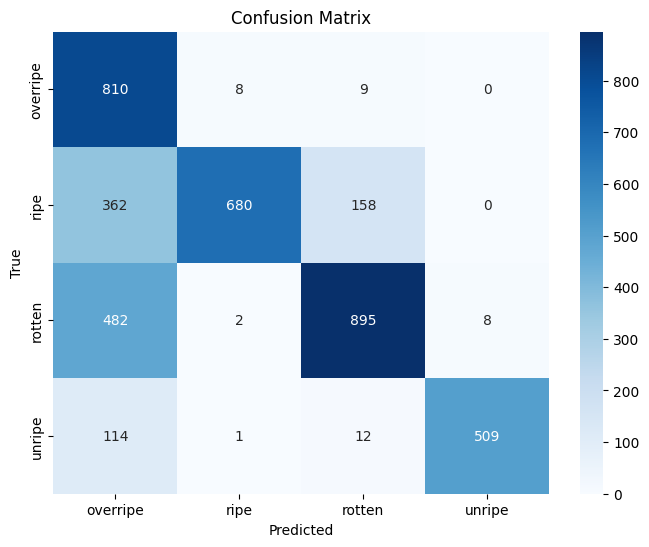

Classification Report:              precision    recall  f1-score   support

    overripe       0.46      0.98      0.62       827
        ripe       0.98      0.57      0.72      1200
      rotten       0.83      0.65      0.73      1387
      unripe       0.98      0.80      0.88       636

    accuracy                           0.71      4050
   macro avg       0.82      0.75      0.74      4050
weighted avg       0.83      0.71      0.73      4050



In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
y_pred_probs = best_model.predict(X_test) #model tahmini
y_pred = np.argmax(y_pred_probs, axis=1) # model tahmini
#doğruluk
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

#Precision, Recall ve F1 Score Hesaplama:
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1:.4f}')

#Confusionmatrixi  Görselleştirme:
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#Sınıflandırma Raporu Yazdırma:
class_report = classification_report(y_test, y_pred, target_names=labels)
print('Classification Report:'+ class_report)


In [21]:
#soru2
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

9406464/9406464 [==============================] - 1s 0us/step


In [22]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [23]:
for layer in base_model.layers:
    layer.trainable = False

In [24]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [26]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
265/265 [==============================] - 51s 173ms/step - loss: 1.1621 - accuracy: 0.5642 - val_loss: 0.9427 - val_accuracy: 0.6180
Epoch 2/10
265/265 [==============================] - 42s 157ms/step - loss: 0.8828 - accuracy: 0.6391 - val_loss: 0.9079 - val_accuracy: 0.6307
Epoch 3/10
265/265 [==============================] - 44s 166ms/step - loss: 0.8437 - accuracy: 0.6566 - val_loss: 0.8254 - val_accuracy: 0.6751
Epoch 4/10
265/265 [==============================] - 45s 168ms/step - loss: 0.8201 - accuracy: 0.6698 - val_loss: 0.8281 - val_accuracy: 0.6677
Epoch 5/10
265/265 [==============================] - 45s 169ms/step - loss: 0.8132 - accuracy: 0.6719 - val_loss: 0.8178 - val_accuracy: 0.6730
Epoch 6/10
265/265 [==============================] - 42s 157ms/step - loss: 0.7963 - accuracy: 0.6785 - val_loss: 0.8213 - val_accuracy: 0.6656
Epoch 7/10
265/265 [==============================] - 45s 169ms/step - loss: 0.7820 - accuracy: 0.6843 - val_loss: 0.8010 - val_ac

In [27]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

127/127 [==============================] - 17s 119ms/step
Test Accuracy: 0.7037
Precision: 0.7253
Recall: 0.7037
F1 Score: 0.6998
Confusion Matrix:


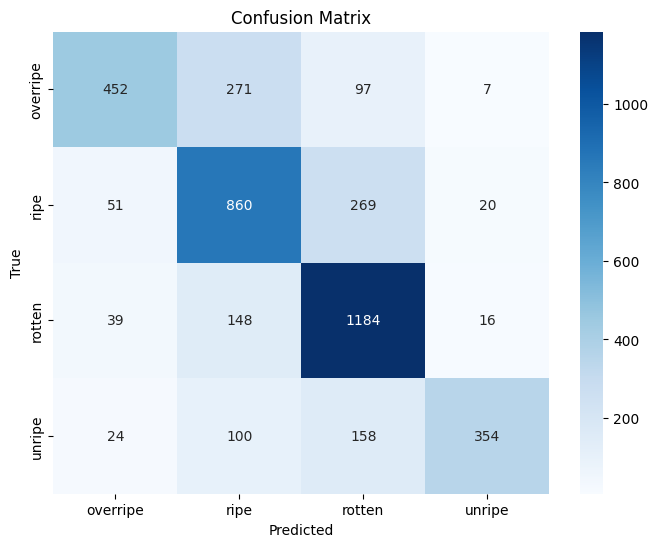

Classification Report:
              precision    recall  f1-score   support

    overripe       0.80      0.55      0.65       827
        ripe       0.62      0.72      0.67      1200
      rotten       0.69      0.85      0.77      1387
      unripe       0.89      0.56      0.69       636

    accuracy                           0.70      4050
   macro avg       0.75      0.67      0.69      4050
weighted avg       0.73      0.70      0.70      4050



In [28]:
# Gerekli kütüphanelerin import edilmesi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
# Modelin test verisi üzerinde tahmin yapması
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
# Doğruluk (Accuracy) metriğinin hesaplanması ve ekrana yazdırılması
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
# Precision, Recall,F1 Score,confusion   metriğinin hesaplanması ve ekrana yazdırılması
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Sınıflandırma Raporunun hesaplanması ve ekrana yazdırılması
class_report = classification_report(y_test, y_pred, target_names=labels)
print('Classification Report:')
print(class_report)

In [29]:
#3. soru
from keras.applications.efficientnet import EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

16705208/16705208 [==============================] - 1s 0us/step


In [30]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [31]:
# Modelin derlenmesi (compile) işlemi
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, num_classes=4)
y_val_encoded = to_categorical(y_val, num_classes=4)

In [33]:
history = model.fit(datagen.flow(X_train, y_train_encoded, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=10, validation_data=(X_val, y_val_encoded))

Epoch 1/10
265/265 [==============================] - 280s 941ms/step - loss: 0.3853 - accuracy: 0.8784 - val_loss: 0.2412 - val_accuracy: 0.9354
Epoch 2/10
265/265 [==============================] - 241s 906ms/step - loss: 0.1867 - accuracy: 0.9414 - val_loss: 0.3214 - val_accuracy: 0.9090
Epoch 3/10
265/265 [==============================] - 247s 930ms/step - loss: 0.1546 - accuracy: 0.9515 - val_loss: 0.1411 - val_accuracy: 0.9503
Epoch 4/10
265/265 [==============================] - 239s 898ms/step - loss: 0.1218 - accuracy: 0.9573 - val_loss: 0.1516 - val_accuracy: 0.9492
Epoch 5/10
265/265 [==============================] - 263s 991ms/step - loss: 0.1273 - accuracy: 0.9586 - val_loss: 0.1823 - val_accuracy: 0.9460
Epoch 6/10
265/265 [==============================] - 245s 924ms/step - loss: 0.1015 - accuracy: 0.9684 - val_loss: 0.1969 - val_accuracy: 0.9545
Epoch 7/10
265/265 [==============================] - 244s 920ms/step - loss: 0.0996 - accuracy: 0.9661 - val_loss: 0.1331 -

In [34]:
 import itertools
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

127/127 [==============================] - 26s 184ms/step
Test Accuracy: 0.9691
Precision: 0.9693
Recall: 0.9691
F1 Score: 0.9691
Confusion Matrix:


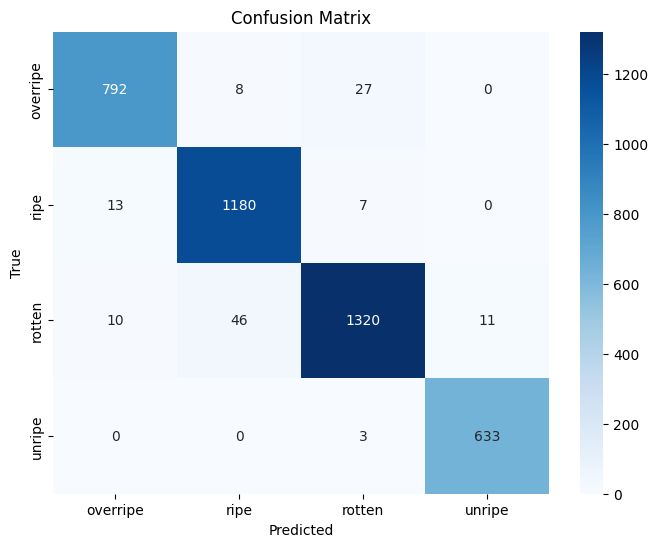

Classification Report:
              precision    recall  f1-score   support

    overripe       0.97      0.96      0.96       827
        ripe       0.96      0.98      0.97      1200
      rotten       0.97      0.95      0.96      1387
      unripe       0.98      1.00      0.99       636

    accuracy                           0.97      4050
   macro avg       0.97      0.97      0.97      4050
weighted avg       0.97      0.97      0.97      4050



In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
# Modelin test verisi üzerinde tahmin yapması
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
# Doğruluk (Accuracy) metriğinin hesaplanması ve ekrana yazdırılması
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
# Precision,f1 score , recall, confusion matrix metriğinin hesaplanması ve ekrana yazdırılması
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Sınıflandırma Raporunun hesaplanması ve ekrana yazdırılması
class_report = classification_report(y_test, y_pred, target_names=labels)
print('Classification Report:')
print(class_report)